# Goal: Policy Gradients and the Gym Environment

The goal of this demo is to get familiar with the [Gymansium](https://gymnasium.farama.org) library and implement REINFORCE, a policy gradient algorithm for Reinforcement Learning. In particular, we will use REINFORCE to solve the [CartPole](https://jeffjar.me/cartpole.html) environment provided by Gym. 

**Small note: we will be using OpenAI's [Gym Library](https://github.com/openai/gym#important-notice) rather than Gymnasium**

Reinforcement Learning is fundmantally a problem in sequential decision making. The following diagram from the [seminal text in the field](http://incompleteideas.net/book/the-book-2nd.html) describes it well:

![](http://www.incompleteideas.net/book/ebook/figtmp7.png)

We have an *agent* that exists in some *environment*. At each timestep, the agent receives an observation that encapsulates the state of the environment (denoted as $s$) and takes an action $a$ based on this state. This mapping from states to actions is known as the agent's policy $\pi$. After taking an action, the state of the environment is updated. 

Additionally at each time step, the agent will receive a reward signal $r$ from the environment. Thus the goal of our agent is to figure out the best policy where “best” is defined in terms of maximizing the rewards ([see class notes](https://chinmayhegde.github.io/dl-notes/notes/lecture09/#setup)).

## Imports

Let's begin by importing our favorite packages. We will also import `gym`. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import gym

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print(torch.cuda.is_available())

True


We will also import turn off deprecation warnings since we are using a slighly outdated library.

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## The CartPole-v1 Environment

Let's instantiate the `CartPole-v1` environment. We can render what our CartPole environment looks like. The environment will remain static unless we call `env.step()`.

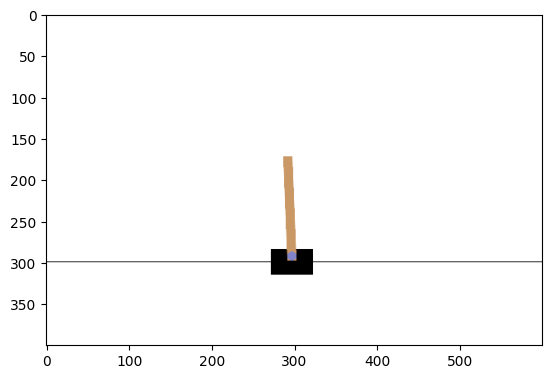

In [11]:
env = gym.make("CartPole-v1")
env.reset()
plt.imshow(env.render(mode='rgb_array'))

So we can see that we have a pole attached to a cart that can move in the x-direction. And our goal is to keep the pole upright.

## What are the actions, states, reward function for CartPole-v1?
Now, let's concretize our understanding by looking at the action, state, and reward space. As we go through this section, do a sanity check with the [CartPole-v1 documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/). 

### [Action Space](https://gymnasium.farama.org/environments/classic_control/cart_pole/#action-space)

In [12]:
print(env.action_space)

Discrete(2)


So, our action space consists of two discrete decisions: move left (0) or move right (1). We can perform a uniform sample over the action space directly from `env`. 

In [13]:
print("Uniformly choosing an action:", env.action_space.sample())

Uniformly choosing an action: 0


Try running the above cell a few times. 

### [Observation (State) Space](https://gymnasium.farama.org/environments/classic_control/cart_pole/#observation-space)

In [14]:
print(env.observation_space.shape) # state space

(4,)


Our `state` will consist of four items:
- the cart position
- the cart velocity
- the pole angle
- the pole's angular velocity

These are continuous variables and some of them are bounded. We can print out the bounds like so:

In [15]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


### [Reward](https://gymnasium.farama.org/environments/classic_control/cart_pole/#rewards)

We just receive a reward of `+1` for every time step until our pole falls over. If we keep the pole upright for more than 475 timesteps, that means we have solved the CartPole-v1 environent.


### A Random Policy $\pi$
Let's create a random policy $\pi$ that simply takes a random action at each timestep. We will play for a maximum of 500 timesteps and if we crash, we will break out of our loop.

In [16]:
rewards = []
for idx in range(500):
   action = env.action_space.sample()                # return either a 0 (for move left) or a 1 (for move right)
   state, reward, terminated, _  = env.step(action)  # performs the action in our environment.
   rewards.append(reward)
   if terminated:
     break
print("number of steps before we crashed:", idx)

number of steps before we crashed: 17


So we made it 17 timesteps before our pole fell over! Let's visualize and print the final state of our environment.

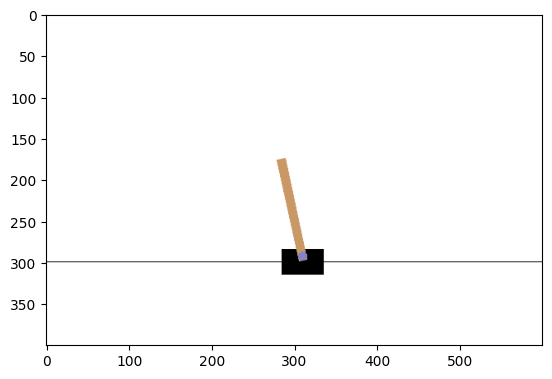

In [17]:
plt.imshow(env.render(mode='rgb_array'))

Check the [termination rules](https://gymnasium.farama.org/environments/classic_control/cart_pole/#episode-end) for CartPole to understand why our episode terminated.

In [21]:
print(state)

[ 0.08003918  0.84610975 -0.21306242 -1.6377889 ]


In [22]:
print("Degree of pole:", np.rad2deg(-0.21306242))

Degree of pole: -12.207577438843742


Let's calculate our cumulative reward for our episode. It's common to sum the individual rewards starting at time step and discounting future rewards as follows:

$R = r_0 + \gamma r_1 + \gamma^2 r_2 \ldots$

In [23]:
print(rewards)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


We will set our discount factor to $\gamma=0.9$.

In [45]:
R = 0
gamma = 0.9
for i in range(len(rewards)):
  R += rewards[i] * gamma**i

print(R)

8.499053647030008


So, it looks like we achieved a cumulative, discounted reward of 8.499. If we had solved the CartPole-v1 environment, we should have achieved a cumulative, discounted reward in the 400s!

## Building a Policy Network

Let's now build a policy network and use the REINFORCE algorithm to solve the CartPole-v1 environment. First, we will instantiate two CartPole-v1 environments: one for training and one for evaluation.

In [26]:
train_env = gym.make('CartPole-v1')
test_env  = gym.make('CartPole-v1')

Recall that our goal is to create a policy $\pi$ that maps states to actions. We will use a small neural network for this.

$\pi(a|s) = P[A = a | S = s]$

In [27]:
class PolicyNet(nn.Module):
  def __init__(self, state_space_size, hidden_dim, action_space_size, dropout=.5):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(state_space_size, hidden_dim), # 4 -> hidden_dim
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(hidden_dim, action_space_size) # hidden_dim -> 2
    )

  def forward(self, x):
    return self.net(x)

Let's obtain the input and output dimensions of the policy network. We already know these values since we understand our environment but it's best to be Pythonic. We will also set the hidden dimension size here.

In [31]:
input_dim = train_env.observation_space.shape[0]
print('input dim:', input_dim)

output_dim = train_env.action_space.n
print('output dim:', output_dim)

hidden_dim = 128

input dim: 4
output dim: 2


Let's instantiate both the network and the optimizer.

In [42]:
policy = PolicyNet(input_dim, hidden_dim, output_dim)
print(policy)

optimizer = optim.Adam(policy.parameters(), lr=0.01)

PolicyNet(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


As it stand now, our policy network output a vector of size 2 which contains real values. We need to convert this to a proper probability distribution over two discrete outcomes. To do this, we will 
- normalize our output
- convert this normalized vector to a torch distribution

The following code snippet shows how we can do this.

In [ ]:
output = torch.randn(2,)                   # output of network
print("output:", output)
probs = F.softmax(output, dim=-1)          # normalize using softmax
print("probs:", probs)
dist = distributions.Categorical(probs)    # convert to discrete distribution
print(dist)
sample = dist.sample()                     # sample from our distribution
print("sample:", sample)
print('log probl:', dist.log_prob(sample)) # find the log_prob of our sample

output: tensor([ 1.1884, -0.2575])
probs: tensor([0.8094, 0.1906])
Categorical(probs: torch.Size([2]))
sample: tensor(0)
log probl: tensor(-0.2115)


In [ ]:
np.log(0.8094)

-0.21146204654037185

You will see that we also measured the log probability of our sample in the above code snippet. We will need to calculate the log probability for the REINFORCE algorithm.

## REINFORCE Algorithm (from [class notes](https://chinmayhegde.github.io/dl-notes/notes/lecture09/#policy-gradients))

The following is the REINFORCE algorithm covered in class. I'd highly suggest going over the class notes to understand how the log-derivative trick is employed.

- Sample a trajectory/rollout $(s_0,a_0, s_1, a_1, \ldots, s_T, a_T)$
- For each $t=0, 1, \ldots, T-1$:
  - Compute $R_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} $
  - $\theta \leftarrow \theta + \eta R_t \frac{d}{d\theta}log\left(\pi(a_t|s_t)\right)$

## Calculating the Return for an Episode

In class, we described how to compute a single discounted reward of a trajectory. In practice, we want to leverage our data for more updates. We do this by considering the future discounted reward for *every* state in our trajectory.

In [33]:
def calculate_returns(rewards, discount_factor, normalize=True):
  returns = []
  R = 0
  for r in reversed(rewards):
    R = r + R * discount_factor
    returns.insert(0,R)

    
  returns = torch.tensor(returns)
  # Remember we normalize to differentiate between
  # "good" and "bad" actions
  if normalize:
    returns = (returns - returns.mean()) / returns.std()
  
  return returns

Let's go ahead and run this cell for the rewards we obtained during our random policy run.

In [34]:
calculate_returns(rewards, 0.9, False)

tensor([8.4991, 8.3323, 8.1470, 7.9411, 7.7123, 7.4581, 7.1757, 6.8619, 6.5132,
        6.1258, 5.6953, 5.2170, 4.6856, 4.0951, 3.4390, 2.7100, 1.9000, 1.0000])

Note that the first value in our `returns` tensor is the same value we calculated above (8.499)! Each value in the `returns` tensor calculates the discounted reward *starting from that time step and up to the end of the episode*. It's common to normalize the returns.

In [35]:
calculate_returns(rewards, 0.9, True)

tensor([ 1.1837,  1.1119,  1.0321,  0.9434,  0.8449,  0.7354,  0.6138,  0.4786,
         0.3285,  0.1616, -0.0237, -0.2297, -0.4586, -0.7129, -0.9955, -1.3094,
        -1.6583, -2.0459])

## Gradient Calculation
Once we have returns and log probabilities of the actions we take, we will compute the loss and optimize. Note the negative sign in this `loss` expression. Can you see why we need to add the negative sign?

In [36]:
def update_policy(returns, log_prob_actions, optimizer):
  returns = returns.detach()
  # Because we minimize (by convention) and we actually
  # want to maximize returns, we negate the expected sum
  loss = - (returns * log_prob_actions).sum()
  optimizer.zero_grad()

  loss.backward()
  optimizer.step()

  return loss.item()

# Training Function

Now we write the training and evaluation functions. Notice how training in RL is more involved than our standard applications.




In [38]:
def train(env, policy, optimizer, discount_factor=.99):
  policy.train()
  
  log_prob_actions = []
  rewards = []
  done = False
  episode_reward = 0

  state = env.reset()

  while not done:
    state = torch.FloatTensor(state).unsqueeze(0)
    action_pred = policy(state)
    action_prob = F.softmax(action_pred, dim = -1) # normalize our output

    dist = distributions.Categorical(action_prob)
    action = dist.sample() # we sample (rather than take the best)
    log_prob_action = dist.log_prob(action)

    state, reward, done, _ = env.step(action.item())

    log_prob_actions.append(log_prob_action)
    rewards.append(reward)

    episode_reward += reward
  
  log_prob_actions = torch.cat(log_prob_actions)
  returns = calculate_returns(rewards, discount_factor)
  loss = update_policy(returns, log_prob_actions, optimizer)

  return loss, episode_reward

# Evaluation Function

The evaluation loop is similar expect we take the best action (i.e. the action that leads to the highest cumulative, discounted reward).

In [39]:
def evaluate(env, policy, return_frames=False):
  policy.eval()

  done = False
  episode_reward = 0
  state = env.reset()
  frames = []

  while not done:
    if return_frames:
      frames += [env.render(mode='rgb_array')]
    state = torch.FloatTensor(state).unsqueeze(0)

    action_pred = policy(state)
    action_prob = F.softmax(action_pred, dim=-1)

    action = torch.argmax(action_prob, dim=-1) # we take the best
    state, reward, done, _ = env.step(action.item())
    episode_reward += reward
  
  if return_frames:
    return episode_reward, frames
  return episode_reward

Let's evaluate our untrained policy network in our `test_env`.

In [40]:
evaluate(test_env, policy)

11.0

## Training

Now we're ready to train. Notice the very jagged nature of the loss history. This is because RL is different from our regular training: our policy is stochastic and the reward is more "sparse".

In [43]:
max_episodes = 500
num_trials = 25
reward_threshold = 475
print_every = 10

train_rewards = []
test_rewards = []

for episode in range(1, max_episodes+1):
  loss, train_reward = train(train_env, policy, optimizer)
  test_reward = evaluate(test_env, policy)

  train_rewards += [train_reward]
  test_rewards += [test_reward]

  mean_train_rewards = np.mean(train_rewards[-num_trials:])
  mean_test_rewards = np.mean(test_rewards[-num_trials:])

  if episode % print_every == 0:    
    print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')
    
  if mean_test_rewards >= reward_threshold:
    print(f'Reached reward threshold in {episode} episodes')
    break

| Episode:  10 | Mean Train Rewards:  19.9 | Mean Test Rewards:  25.2 |
| Episode:  20 | Mean Train Rewards:  24.9 | Mean Test Rewards:  67.4 |
| Episode:  30 | Mean Train Rewards:  37.6 | Mean Test Rewards:  90.2 |
| Episode:  40 | Mean Train Rewards:  54.1 | Mean Test Rewards: 113.6 |
| Episode:  50 | Mean Train Rewards:  66.6 | Mean Test Rewards: 112.8 |
| Episode:  60 | Mean Train Rewards:  74.0 | Mean Test Rewards: 136.2 |
| Episode:  70 | Mean Train Rewards:  87.6 | Mean Test Rewards: 254.0 |
| Episode:  80 | Mean Train Rewards:  97.4 | Mean Test Rewards: 334.6 |
| Episode:  90 | Mean Train Rewards: 126.6 | Mean Test Rewards: 373.3 |
| Episode: 100 | Mean Train Rewards: 157.4 | Mean Test Rewards: 380.4 |
| Episode: 110 | Mean Train Rewards: 148.5 | Mean Test Rewards: 315.2 |
| Episode: 120 | Mean Train Rewards: 198.8 | Mean Test Rewards: 313.5 |
| Episode: 130 | Mean Train Rewards: 310.8 | Mean Test Rewards: 369.7 |
Reached reward threshold in 138 episodes


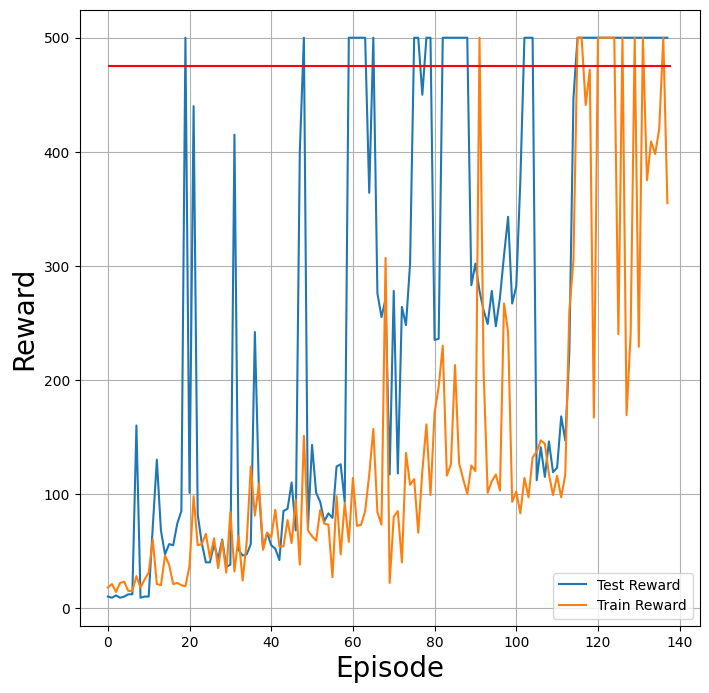

In [44]:
plt.figure(figsize=(8,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(reward_threshold, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()

And that's it! We went over the basic setup of Reinforcement Learning, talked about the gym environment, and used the REINFORCE algorithm to solve the cartpole environment.